In [1]:
%matplotlib inline
import sys
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import skimage
import skimage.io as io
import copy
from collections import defaultdict
import cv2

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
colors_recykling = {'metals_and_plastics':'yellow',
                    'non-recyclable': 'gray',
                    'unknown':'gray',
                    'glass': 'green',
                    'paper': 'blue',
                    'bio': 'brown',
                    'other': 'pink'}

# waste pictures
- classes: 34
- annotation: class per image

In [4]:
dataDir = '/dih4/dih4_2/wimlds/data/waste-pictures'
categories = os.listdir(os.path.join(dataDir,'test'))
images = []
nr_images = 0
for category in categories:
    for img in os.listdir(os.path.join(dataDir,'test',category)):        
        images.append(f'{dataDir}/test/{category}/{img}')
    nr_images+=len(os.listdir(os.path.join(dataDir,'test',category)))
for category in categories:
    for img in os.listdir(os.path.join(dataDir,'train',category)):        
        images.append(f'{dataDir}/train/{category}/{img}')
    nr_images+=len(os.listdir(os.path.join(dataDir,'train',category)))
    
nr_cats = len(categories)

print(f'There are {len(categories)} categories.')
print(f'There are {nr_images} images')

There are 34 categories.
There are 23633 images


diapers diaper (559).jpg
traditionalChinesemedicine traditionalChinesemedicine (26).jpg
cigarettebutt cigarettebutt (15).jpg
plasticbottle plasticbottle (140).jpg


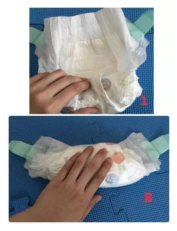

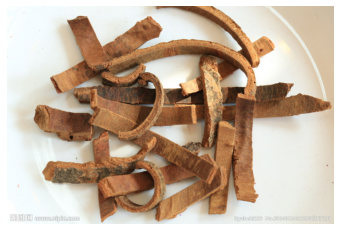

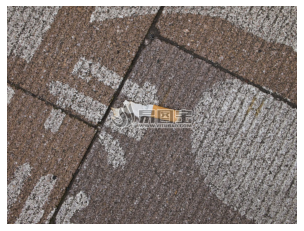

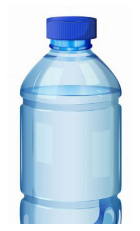

In [5]:
#load and display image
import random
for i in range(1,5):
    rand_cat = random.choice(categories)
    img_name = random.choice(os.listdir(os.path.join(os.path.join(dataDir,'train'),rand_cat)))    
    I = io.imread(os.path.join(dataDir,'train',rand_cat,img_name))
    plt.figure()
    plt.imshow(I)
    plt.axis('off')
    print(rand_cat, img_name)


In [6]:
test_categories_count = {category: len(os.listdir(os.path.join(dataDir,'test',category))) for category in categories}
test_categories_count

{'XLight': 200,
 'bandaid': 121,
 'battery': 205,
 'bowlsanddishes': 205,
 'bread': 233,
 'bulb': 205,
 'cans': 209,
 'carton': 134,
 'chopsticks': 96,
 'cigarettebutt': 44,
 'diapers': 211,
 'facialmask': 203,
 'glassbottle': 201,
 'leaflet': 198,
 'leftovers': 209,
 'medicinebottle': 198,
 'milkbox': 79,
 'nailpolishbottle': 327,
 'napkin': 142,
 'newspaper': 200,
 'nut': 75,
 'penholder': 210,
 'pesticidebottle': 203,
 'plasticbag': 219,
 'plasticbottle': 116,
 'plasticene': 219,
 'rag': 134,
 'tabletcapsule': 206,
 'thermometer': 208,
 'toothbrush': 109,
 'toothpastetube': 114,
 'toothpick': 34,
 'traditionalChinesemedicine': 74,
 'watermelonrind': 216}

In [7]:
train_categories_count = {category: len(os.listdir(os.path.join(dataDir,'train',category))) for category in categories}
train_categories_count

{'XLight': 755,
 'bandaid': 292,
 'battery': 840,
 'bowlsanddishes': 610,
 'bread': 732,
 'bulb': 681,
 'cans': 596,
 'carton': 173,
 'chopsticks': 195,
 'cigarettebutt': 54,
 'diapers': 567,
 'facialmask': 601,
 'glassbottle': 422,
 'leaflet': 683,
 'leftovers': 930,
 'medicinebottle': 526,
 'milkbox': 128,
 'nailpolishbottle': 986,
 'napkin': 442,
 'newspaper': 763,
 'nut': 192,
 'penholder': 882,
 'pesticidebottle': 737,
 'plasticbag': 751,
 'plasticbottle': 184,
 'plasticene': 755,
 'rag': 440,
 'tabletcapsule': 701,
 'thermometer': 700,
 'toothbrush': 362,
 'toothpastetube': 253,
 'toothpick': 98,
 'traditionalChinesemedicine': 35,
 'watermelonrind': 810}

In [8]:
all_categories_count = {category: len(os.listdir(os.path.join(dataDir,'test',category)))+len(os.listdir(os.path.join(dataDir,'train',category))) for category in categories}
all_categories_count

{'XLight': 955,
 'bandaid': 413,
 'battery': 1045,
 'bowlsanddishes': 815,
 'bread': 965,
 'bulb': 886,
 'cans': 805,
 'carton': 307,
 'chopsticks': 291,
 'cigarettebutt': 98,
 'diapers': 778,
 'facialmask': 804,
 'glassbottle': 623,
 'leaflet': 881,
 'leftovers': 1139,
 'medicinebottle': 724,
 'milkbox': 207,
 'nailpolishbottle': 1313,
 'napkin': 584,
 'newspaper': 963,
 'nut': 267,
 'penholder': 1092,
 'pesticidebottle': 940,
 'plasticbag': 970,
 'plasticbottle': 300,
 'plasticene': 974,
 'rag': 574,
 'tabletcapsule': 907,
 'thermometer': 908,
 'toothbrush': 471,
 'toothpastetube': 367,
 'toothpick': 132,
 'traditionalChinesemedicine': 109,
 'watermelonrind': 1026}

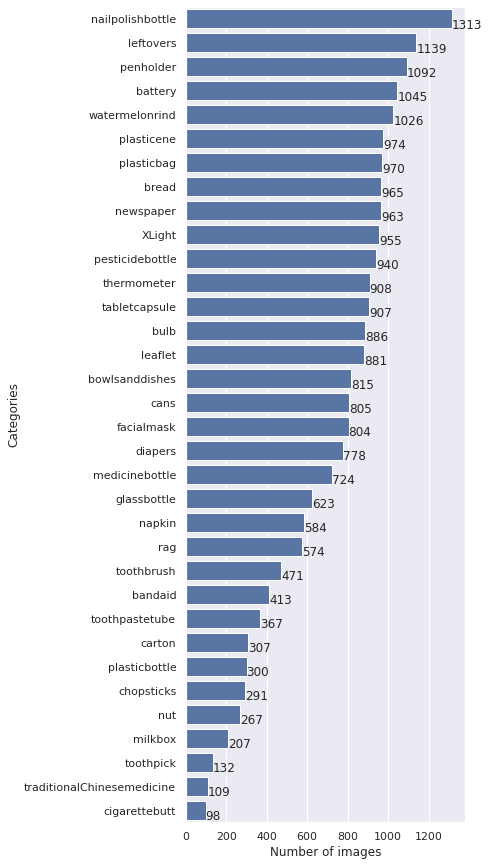

In [9]:
f, ax = plt.subplots(figsize=(5,15))

cat_histogram = np.array([all_categories_count[category] for category in categories])

# Convert to DataFrame
df = pd.DataFrame({'Categories': categories, 'Number of images': cat_histogram})
df = df.sort_values('Number of images', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of images", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [10]:
def wastepictures_to_detectwaste(label):
    glass = ['glassbottle']
    metals_and_plastics = ['cans','milkbox','pesticidebottle','plasticbag','plasticbottle']    
    non_recyclable = ['bandaid', 'bowlsanddishes','cigarettebutt','diapers',
                     'facialmask','leftovers', 'medicinebottle','nailpolishbottle',
                     'napkin','penholder','plasticene','rag','tabletcapsule','toothbrush',
                     'toothpastetube']    
    other = ['battery','bulb','thermometer']
    paper = ['carton','leaflet','newspaper']
    bio = ['bread', 'chopsticks','nut','toothpick','watermelonrind']
    unknown = ['traditionalChinesemedicine','XLight']

    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
    elif(label in non_recyclable):
            label="non-recyclable"
    elif(label in other):
            label="other"
    elif (label in paper):
            label="paper"
    elif(label in bio):
            label="bio"
    elif(label in unknown):
            label="unknown"
    else:
        print(label, "is non-wastepicture label")
        label = "unknown"
    return label

In [11]:
detect_waste_count = defaultdict(int)
for category in categories:
    detect_waste_count[wastepictures_to_detectwaste(category)]+=all_categories_count[category]
detect_waste_categories = list(detect_waste_count.keys())
detect_waste_count

defaultdict(int,
            {'unknown': 1064,
             'non-recyclable': 11053,
             'other': 2839,
             'bio': 2681,
             'metals_and_plastics': 3222,
             'paper': 2151,
             'glass': 623})

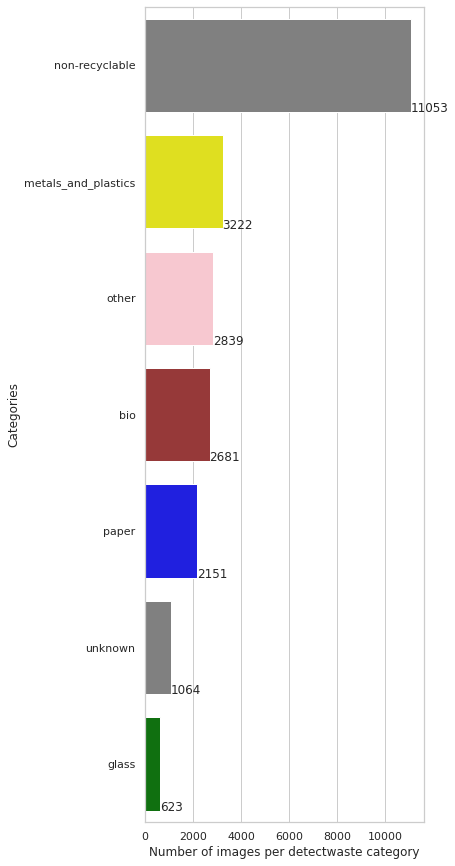

In [12]:

f, ax = plt.subplots(figsize=(5,15))

detect_waste_cat_histogram = np.array([detect_waste_count[category] for category in detect_waste_categories])

# Convert to DataFrame
df = pd.DataFrame({'Categories': detect_waste_categories, 'Number of images per detectwaste category': detect_waste_cat_histogram})
df = df.sort_values('Number of images per detectwaste category', 0, False)

# Plot the histogram
sup_cat = df.loc[:,'Categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set(style="whitegrid")
sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of images per detectwaste category", y="Categories", data=df,
            label="Total")
show_values_on_bars(plot_1, "h", 0.3)

### Number of images per image shape

/home/zklawikowska/project/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


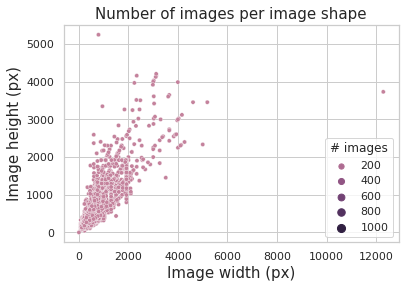

In [13]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}

for img in images:
    try:
        im = plt.imread(img)
        width=np.shape(im)[1]
        height=np.shape(im)[0]

        key = str(width)+'-'+str(height)
        if key in img_shapes_keys:
            shape_id = img_shapes_keys[key]
            shape_freqs[shape_id] += 1
        else:
            img_shapes_keys[key] = len(widths)
            widths.append(width)
            heights.append(height)
            shape_freqs.append(1)
    except:
        pass

d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)